Epoch 1/12
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0330 - mean_absolute_error: 0.1360 - val_loss: 6.2553e-05 - val_mean_absolute_error: 0.0075 - learning_rate: 0.0010
Epoch 2/12
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0084 - mean_absolute_error: 0.0699 - val_loss: 6.5460e-05 - val_mean_absolute_error: 0.0077 - learning_rate: 0.0010
Epoch 3/12
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0069 - mean_absolute_error: 0.0651 - val_loss: 7.5713e-05 - val_mean_absolute_error: 0.0082 - learning_rate: 0.0010
Epoch 4/12
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0062 - mean_absolute_error: 0.0607 - val_loss: 7.0804e-05 - val_mean_absolute_error: 0.0078 - learning_rate: 0.0010
Epoch 5/12
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0058 - mean_absolute_error: 0.0599 - val_loss: 1.1588e-04 - val_mean_absolute_error: 0.0101 - learning_rate: 0.0010
Epoch 6/12
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0055 - mean_absolute_error: 0.0571 - val_loss: 8.7433e

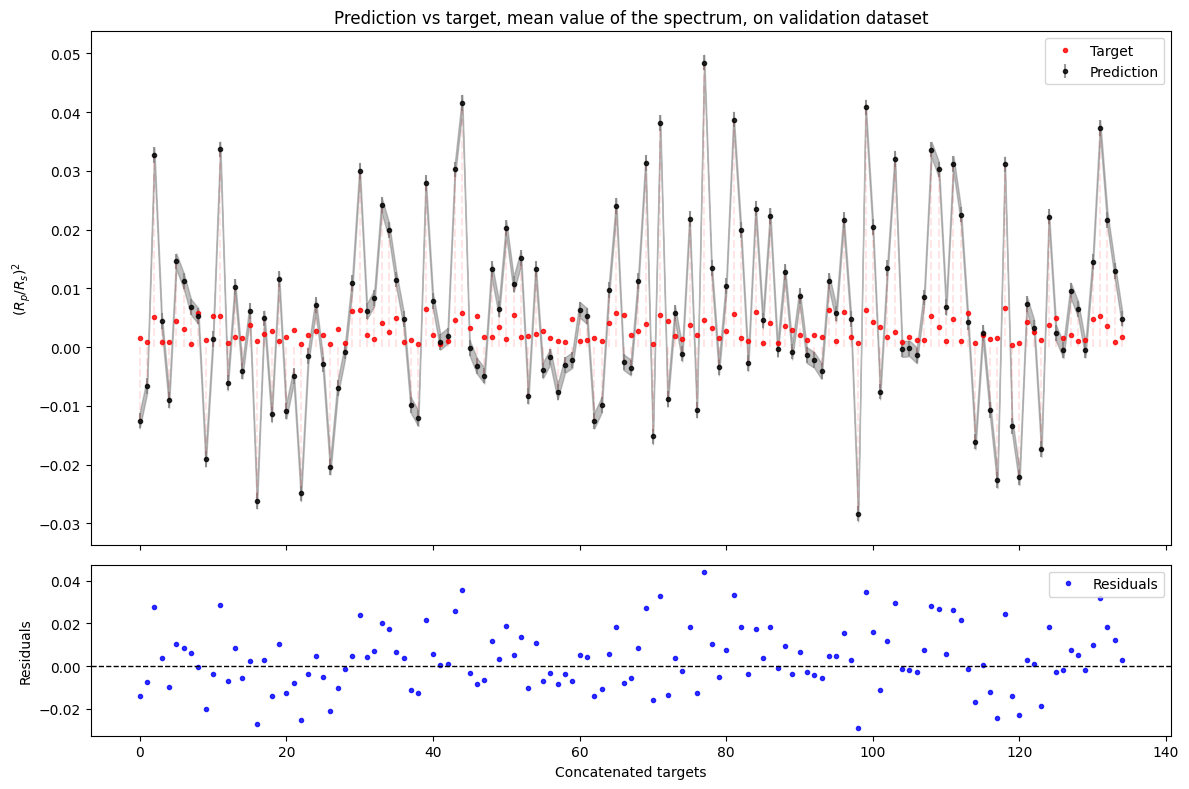

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError


# =======================================================
# DATA LOADING
# =======================================================
def load_data():
    """Load datasets and target labels."""
    # Load target labels
    train_solution = np.loadtxt(r"C:\Users\axelp\Desktop\Travail\DeepLearning\train_labels.csv", delimiter=',', skiprows=1)
    targets = train_solution[:, 1:]
    targets_mean = targets[:, 1:].mean(axis=1)
    
    # Load AIRS and FGS datasets
    df = np.load(r"C:\Users\axelp\Desktop\Travail\DeepLearning\data_train.npy")
    dfFGS = np.load(r"C:\Users\axelp\Desktop\Travail\DeepLearning\data_train_FGS.npy")

    # Combine AIRS and FGS data into a unified dataset
    FGS_column = dfFGS.sum(axis=2)
    dataset = np.concatenate([df, FGS_column[:, :, np.newaxis, :]], axis=2)
    dataset = dataset.sum(axis=3)

    # Limit dataset size for computational efficiency
    max_size = 10000
    dataset = dataset[:max_size]
    targets = targets[:max_size]

    return dataset, targets, targets_mean


# =======================================================
# PREPROCESSING
# =======================================================
def preprocess_data(dataset, targets_mean):
    """Preprocess the dataset for training and validation."""
    def norm_star_spectrum(signal):
        img_star = signal[:, :50].mean(axis=1) + signal[:, -50:].mean(axis=1)
        return signal / img_star[:, np.newaxis, :]

    # Normalize spectrum data
    dataset_norm = norm_star_spectrum(dataset)
    dataset_norm = np.transpose(dataset_norm, (0, 2, 1))

    # Split dataset
    def split(data, targets, train_ratio=0.8):
        N = data.shape[0]
        indices = np.arange(N)
        random.shuffle(indices)
        split_idx = int(train_ratio * N)
        train_idx, valid_idx = indices[:split_idx], indices[split_idx:]
        return data[train_idx], targets[train_idx], data[valid_idx], targets[valid_idx]

    train_data, train_targets, val_data, val_targets = split(dataset_norm, targets_mean)

    # Normalize training and validation datasets
    def normalize(data):
        data_min = data.min()
        data_max = data.max()
        return (data - data_min) / (data_max - data_min), data_min, data_max

    train_data, train_min, train_max = normalize(train_data)
    val_data, _, _ = normalize(val_data)

    return train_data, train_targets, val_data, val_targets, train_min, train_max


# =======================================================
# CORE DEEP LEARNING MODEL
# =======================================================
def build_model(input_shape):
    """Define and compile the 1D CNN model."""
    input_wc = Input(input_shape)
    x = Conv1D(32, 3, activation='relu')(input_wc)
    x = MaxPooling1D()(x)
    x = BatchNormalization()(x)
    x = Conv1D(64, 3, activation='relu')(x)
    x = MaxPooling1D()(x)
    x = Conv1D(128, 3, activation='relu')(x)
    x = MaxPooling1D()(x)
    x = Conv1D(256, 3, activation='relu')(x)
    x = MaxPooling1D()(x)
    x = Flatten()(x)

    x = Dense(500, activation='relu')(x)
    x = Dropout(0.2)(x, training=True)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.1)(x, training=True)
    output_wc = Dense(1, activation='linear')(x)

    model = Model(inputs=input_wc, outputs=output_wc)
    return model


# =======================================================
# OPTIMIZATION
# =======================================================
def compile_and_train_model(model, train_data, train_targets, val_data, val_targets):
    """Compile and train the model."""
    def scheduler(epoch, lr):
        decay_rate = 0.2
        decay_step = 200
        if epoch % decay_step == 0 and epoch:
            return lr * decay_rate
        return lr

    optimizer = SGD(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=[MeanAbsoluteError()])

    # Define callbacks
    callbacks = [
        LearningRateScheduler(scheduler),
        ModelCheckpoint('output/model_1dcnn.keras', save_best_only=True)
    ]

    # Train the model
    history = model.fit(
        train_data, train_targets,
        validation_data=(val_data, val_targets),
        batch_size=16,
        epochs=12,
        shuffle=True,
        verbose=1,
        callbacks=callbacks
    )
    return history


# =======================================================
# EVALUATION, METRICS, AND PLOTS
# =======================================================
import matplotlib.pyplot as plt
import numpy as np

def evaluate_and_plot(predictions, predictions_std, targets):
    """
    Create a combined plot with predictions, uncertainty, targets, and residuals.

    Args:
        predictions: Array of predicted values.
        predictions_std: Array of standard deviations for uncertainty visualization.
        targets: Array of target values (ground truth).
    """
    # Calculate residuals
    residuals = predictions - targets

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Plot predictions with uncertainty and targets (Top subplot)
    ax1.errorbar(
        x=np.arange(len(predictions)),
        y=predictions,
        yerr=predictions_std,
        fmt='.',
        color='black',
        ecolor='gray',
        label='Prediction',
        alpha=0.8
    )
    ax1.fill_between(
        np.arange(len(predictions)),
        predictions - predictions_std,
        predictions + predictions_std,
        color='gray',
        alpha=0.5
    )
    ax1.vlines(
        np.arange(len(predictions)),
        ymin=0,
        ymax=predictions,
        colors='r',
        linestyle='dashed',
        alpha=0.1
    )
    ax1.plot(targets, 'r.', label='Target', alpha=0.8)
    ax1.set_title('Prediction vs target, mean value of the spectrum, on validation dataset')
    ax1.set_ylabel(r'$(R_p/R_s)^2$')
    ax1.legend()

    # Plot residuals (Bottom subplot)
    ax2.plot(residuals, 'b.', label='Residuals', alpha=0.8)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1)  # Add horizontal line at y=0
    ax2.set_xlabel('Concatenated targets')
    ax2.set_ylabel('Residuals')
    ax2.legend()

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


# =======================================================
# MAIN PIPELINE
# =======================================================
def main():
    # Step 1: Data Loading
    dataset, targets, targets_mean = load_data()

    # Step 2: Preprocessing
    train_data, train_targets, val_data, val_targets, train_min, train_max = preprocess_data(dataset, targets_mean)

    # Step 3: Model Creation
    input_shape = (train_data.shape[1], train_data.shape[2])  # Define input shape for CNN
    model = build_model(input_shape)

    # Step 4: Training
    compile_and_train_model(model, train_data, train_targets, val_data, val_targets)

    # Step 5: Evaluation - Generate Predictions
    predictions = model.predict(val_data).flatten()
    # Optional: Standard deviation for uncertainty (if applicable)
    std_devs = np.std(predictions) / np.sqrt(len(predictions))  # Replace with actual uncertainty if calculated

    # Step 6: Plot Evaluation
    evaluate_and_plot(predictions, std_devs, val_targets)


if __name__ == "__main__":
    main()
